## Digit Recognizer
Learn computer vision fundamentals with the famous MNIST dat

https://www.kaggle.com/c/digit-recognizer

### Competition Description
MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.

### Practice Skills
Computer vision fundamentals including simple neural networks

Classification methods such as SVM and K-nearest neighbors

#### Acknowledgements 
More details about the dataset, including algorithms that have been tried on it and their levels of success, can be found at http://yann.lecun.com/exdb/mnist/index.html. The dataset is made available under a Creative Commons Attribution-Share Alike 3.0 license.

In [0]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt, matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
%matplotlib inline

# Tensorflow 2.0

### initiate TF 2.0

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import losses,optimizers,metrics
from tensorflow.keras import layers

In [0]:
from tensorflow.keras.callbacks import TensorBoard

In [0]:
import time


NAME = 'DigiRecognizer-CNN-{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

### Data preparation

In [16]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
labeled_images = pd.read_csv('gdrive/My Drive/dataML/train.csv')
#labeled_images = pd.read_csv('train.csv')
images = labeled_images.iloc[:,1:]
labels = labeled_images.iloc[:,:1]
train_images, test_images,train_labels, test_labels = train_test_split(images, labels, test_size=0.01)

In [18]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(41580, 784)
(41580, 1)
(420, 784)
(420, 1)


### Helper functions for batch learning

In [0]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [0]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        # Vertically stacks the training images
        self.training_images = train_images.values
        train_len = self.training_images.shape[0]
        
        # Reshapes and normalizes training images
        self.training_images = self.training_images.reshape(train_len,28,28,1)/255
        # One hot Encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.training_labels = one_hot_encode(train_labels.values.reshape(-1), 10)
        
        print("Setting Up Test Images and Labels")
        
        # Vertically stacks the test images
        self.test_images = test_images.values
        test_len = self.test_images.shape[0]
        
        # Reshapes and normalizes test images
        self.test_images = self.test_images.reshape(test_len,28,28,1)/255
        # One hot Encodes the test labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.test_labels = one_hot_encode(test_labels.values.reshape(-1), 10)

        
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100
        x = self.training_images[self.i:self.i+batch_size]
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [21]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100

Setting Up Training Images and Labels
Setting Up Test Images and Labels


### Creating the Model Class


In [0]:
class CNNModel(tf.keras.Model):
  def __init__(self):
    super().__init__()
    # self.Dense1 = layers.Dense(units=10, activation='relu')
    self.conv1 = layers.Conv2D(filters=12, kernel_size=(6,6), strides=(1,1), padding='same', activation='relu')
    self.conv2 = layers.Conv2D(filters=24, kernel_size=(5,5), strides=(2,2), padding='same', activation='relu')
    self.conv3 = layers.Conv2D(filters=48, kernel_size=(4,4), strides=(2,2), padding='same', activation='relu')
    self.flatten = layers.Flatten()
    self.dense = layers.Dense(units=10,activation='softmax')

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.flatten(x)
    output = self.dense(x)
    return output

In [0]:
num_epochs = 1000
batch_size = 50
learning_rate = 0.001

### Initialize the model and optimizer

In [0]:
model = CNNModel()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


### Train the model

In [0]:
for epoch in range(num_epochs):
  X, y_true = ch.next_batch(batch_size)
  with tf.GradientTape() as tape:
    y_pred = model(X)
    loss = tf.keras.losses.categorical_crossentropy(y_true=y_true, y_pred=y_pred)
    loss = tf.reduce_mean(loss)

  grad = tape.gradient(loss, model.variables)
  optimizer.apply_gradients(grads_and_vars=zip(grad, model.variables))
  
  if epoch%100 == 0:
    print("epch: {}, loss: {}".format(epoch, loss.numpy()))

### Evaluate the model

In [31]:
categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()

y_pred = model.predict(x = ch.test_images)
categorical_accuracy.update_state(y_true = ch.test_labels, y_pred=y_pred)
accuracy = categorical_accuracy.result().numpy()
print("The accuracy is:{}".format(accuracy))

The accuracy is:0.9785714149475098


### Train and Evaluate the model

In [0]:
categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [27]:
for epoch in range(num_epochs):
  X, y_true = ch.next_batch(batch_size)
  with tf.GradientTape() as tape:
    y_pred = model(X)
    loss = tf.keras.losses.categorical_crossentropy(y_true=y_true, y_pred=y_pred)
    loss = tf.reduce_mean(loss)

  grad = tape.gradient(loss, model.variables)
  optimizer.apply_gradients(grads_and_vars=zip(grad, model.variables))
  
  y_test_pred = model.predict(x = ch.test_images)
  categorical_accuracy.update_state(y_true = ch.test_labels, y_pred=y_test_pred)
  accuracy = categorical_accuracy.result().numpy()

  if epoch%100 == 0:
    print("epch: {}, loss: {}, accuracy: {}".format(epoch, loss.numpy(),accuracy))

epch: 0, loss: 0.24360981583595276, accuracy: 0.9119047522544861
epch: 100, loss: 0.17657403647899628, accuracy: 0.9417491555213928
epch: 200, loss: 0.22644303739070892, accuracy: 0.9487680792808533
epch: 300, loss: 0.0930221825838089, accuracy: 0.9535674452781677
epch: 400, loss: 0.03676765784621239, accuracy: 0.9576594233512878
epch: 500, loss: 0.03941649571061134, accuracy: 0.9618382453918457
epch: 600, loss: 0.005630108527839184, accuracy: 0.9642064571380615
epch: 700, loss: 0.05734631419181824, accuracy: 0.9666293263435364
epch: 800, loss: 0.07206948101520538, accuracy: 0.9687057733535767
epch: 900, loss: 0.029876455664634705, accuracy: 0.9701046347618103


In [26]:
printcategorical_accuracy.result().numpy()

0.9785714

# Tensorflow 1.0

### Helper functions for batch learning

In [0]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [0]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        # Vertically stacks the training images
        self.training_images = train_images.as_matrix()
        train_len = self.training_images.shape[0]
        
        # Reshapes and normalizes training images
        self.training_images = self.training_images.reshape(train_len,28,28,1)/255
        # One hot Encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.training_labels = one_hot_encode(train_labels.as_matrix().reshape(-1), 10)
        
        print("Setting Up Test Images and Labels")
        
        # Vertically stacks the test images
        self.test_images = test_images.as_matrix()
        test_len = self.test_images.shape[0]
        
        # Reshapes and normalizes test images
        self.test_images = self.test_images.reshape(test_len,28,28,1)/255
        # One hot Encodes the test labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.test_labels = one_hot_encode(test_labels.as_matrix().reshape(-1), 10)

        
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100
        x = self.training_images[self.i:self.i+batch_size]
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [0]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


## Creating the Model



** Create 2 placeholders, x and y_true. Their shapes should be: **

* X shape = [None,28,28,1]
* Y_true shape = [None,10]

** Create three more placeholders 
* lr: learning rate
* step：for learning rate decay
* drop_rate

In [0]:
X = tf.placeholder(tf.float32, shape=[None,28,28,1])
Y_true = tf.placeholder(tf.float32, shape=[None,10])

lr = tf.placeholder(tf.float32)
step = tf.placeholder(tf.int32)
drop_rate = tf.placeholder(tf.float32)

### Initialize Weights and bias
 neural network structure for this sample:

X [batch, 28, 28, 1]
 
Layer 1:  conv. layer 6x6x1=>6, stride 1    W1 [6, 6, 1, 6] ,       B1 [6]

Y1 [batch, 28, 28, 6]

Layer 2: conv. layer 5x5x6=>12, stride 2       W2 [5, 5, 6, 12] ,       B2 [12]

Y2 [batch, 14, 14, 12]

Layer 3: conv. layer 4x4x12=>24, stride 2      W3 [4, 4, 12, 24]  ,     B3 [24]

Y3 [batch, 7, 7, 24] => reshaped to YY [batch, 7*7*24]

Layer 4: fully connected layer (relu+dropout), W4 [7*7*24, 200]       B4 [200]

Y4 [batch, 200]

Layer 5: fully connected layer (softmax)      W5 [200, 10]           B5 [10]

Y [batch, 10]

In [0]:
# three convolutional layers with their channel counts, and a
# fully connected layer (the last layer has 10 softmax neurons)
K = 12  # first convolutional layer output depth
L = 24  # second convolutional layer output depth
M = 48  # third convolutional layer
N = 200  # fully connected layer

In [0]:
W1 = tf.Variable(tf.truncated_normal([6,6,1,K], stddev=0.1)) 
B1 = tf.Variable(tf.ones([K])/10)

W2 = tf.Variable(tf.truncated_normal([5,5,K,L], stddev=0.1))
B2 = tf.Variable(tf.ones([L])/10)

W3 = tf.Variable(tf.truncated_normal([4,4,L,M], stddev=0.1))
B3 = tf.Variable(tf.ones([M])/10)

W4 = tf.Variable(tf.truncated_normal([7*7*M,N], stddev=0.1))
B4 = tf.Variable(tf.ones([N])/10)

W5 = tf.Variable(tf.truncated_normal([N, 10], stddev=0.1))
B5 = tf.Variable(tf.zeros([10]))

### layers

In [0]:
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding='SAME') + B1)

Y2 = tf.nn.relu(tf.nn.conv2d(Y1,W2, strides = [1,2,2,1], padding='SAME') + B2)

Y3 = tf.nn.relu(tf.nn.conv2d(Y2,W3, strides = [1,2,2,1], padding='SAME') + B3)

#flat the inputs for the fully connected nn
YY3 = tf.reshape(Y3, shape = (-1,7*7*M))
                

Y4 = tf.nn.relu(tf.matmul(YY3, W4) + B4)
Y4d = tf.nn.dropout(Y4,rate = drop_rate)

Ylogits = tf.matmul(Y4d, W5) + B5
Y = tf.nn.softmax(Ylogits)

### Loss Function

In [0]:
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_true,logits=Ylogits))
cross_entropy = tf.losses.softmax_cross_entropy(onehot_labels = Y_true, logits = Ylogits)
#cross_entropy = -tf.reduce_mean(y_true * tf.log(Ylogits)) * 1000.0 

Instructions for updating:
Use tf.cast instead.


### Optimizer

In [0]:
lr = 0.0001 + tf.train.exponential_decay(learning_rate = 0.003, 
                                         global_step = step,
                                         decay_steps = 2000,
                                         decay_rate = 1/math.e
                                        )

#optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.005)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train = optimizer.minimize(cross_entropy)

### Intialize Variables

In [0]:
init = tf.global_variables_initializer()

### Saving the Model

In [0]:
saver = tf.train.Saver()

## Graph Session

** Perform the training and test print outs in a Tf session and run your model! **

In [0]:
history = {'acc_train':list(),'acc_val':list(),
           'loss_train':list(),'loss_val':list(),
          'learning_rate':list()}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(20000):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={X: batch[0], Y_true: batch[1], step: i, drop_rate: 0.25})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            # Test the Train Model
            feed_dict_train = {X: batch[0], Y_true: batch[1], drop_rate: 0.25}
            feed_dict_val = {X:ch.test_images, Y_true:ch.test_labels, drop_rate: 0}

            matches = tf.equal(tf.argmax(Y,1),tf.argmax(Y_true,1))
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            history['acc_train'].append(sess.run(acc, feed_dict = feed_dict_train))
            history['acc_val'].append(sess.run(acc, feed_dict = feed_dict_val))

            history['loss_train'].append(sess.run(cross_entropy, feed_dict = feed_dict_train))
            history['loss_val'].append(sess.run(cross_entropy, feed_dict = feed_dict_val))
            
            history['learning_rate'].append(sess.run(lr, feed_dict = {step: i}))
            print("Iteration {}:\tlearning_rate={:.6f},\tloss_train={:.6f},\tloss_val={:.6f},\tacc_train={:.6f},\tacc_val={:.6f}"
                  .format(i,history['learning_rate'][-1],
                          history['loss_train'][-1],
                          history['loss_val'][-1],
                          history['acc_train'][-1],
                          history['acc_val'][-1]))
            
            print('\n')
        
    saver.save(sess,'models_saving/my_model.ckpt')

Iteration 0:	learning_rate=0.003100,	loss_train=3.291209,	loss_val=3.566376,	acc_train=0.150000,	acc_val=0.080952


Iteration 100:	learning_rate=0.002954,	loss_train=0.273934,	loss_val=0.113660,	acc_train=0.950000,	acc_val=0.973810


Iteration 200:	learning_rate=0.002815,	loss_train=0.131737,	loss_val=0.094597,	acc_train=0.980000,	acc_val=0.969048


Iteration 300:	learning_rate=0.002682,	loss_train=0.058850,	loss_val=0.089490,	acc_train=0.980000,	acc_val=0.971429


Iteration 400:	learning_rate=0.002556,	loss_train=0.052930,	loss_val=0.051649,	acc_train=0.990000,	acc_val=0.983333


Iteration 500:	learning_rate=0.002436,	loss_train=0.108525,	loss_val=0.043813,	acc_train=0.970000,	acc_val=0.980952


Iteration 600:	learning_rate=0.002322,	loss_train=0.077652,	loss_val=0.043063,	acc_train=0.980000,	acc_val=0.983333


Iteration 700:	learning_rate=0.002214,	loss_train=0.062273,	loss_val=0.050851,	acc_train=0.990000,	acc_val=0.983333


Iteration 800:	learning_rate=0.002111,	loss_train=0.055581

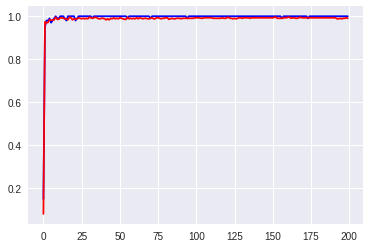

In [0]:
plt.plot(history['acc_train'],'b')
plt.plot(history['acc_val'],'r')

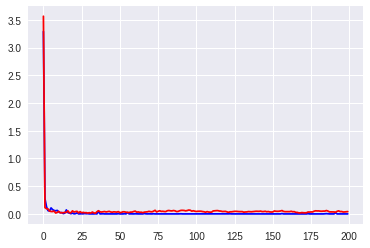

In [0]:
plt.plot(history['loss_train'],'b')
plt.plot(history['loss_val'],'r')

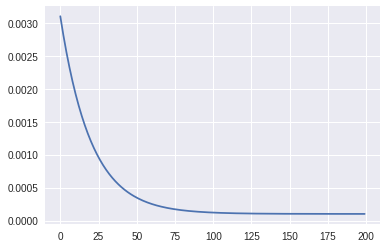

In [0]:
plt.plot(history['learning_rate'])

### Loading a Model

In [0]:
unlabeled_images_test = pd.read_csv('gdrive/My Drive/dataML/test.csv')
#unlabeled_images_test = pd.read_csv('test.csv')

X_unlabeled = unlabeled_images_test.values.reshape(unlabeled_images_test.shape[0],28,28,1)/255

In [0]:
with tf.Session() as sess:
    
    # Restore the model
    saver.restore(sess, 'models_saving/my_model.ckpt')
    

    # Fetch Back Results
    label = sess.run(Y, feed_dict={X:X_unlabeled,drop_rate:0})

INFO:tensorflow:Restoring parameters from models_saving/my_model.ckpt


In [0]:
label

array([2, 0, 9, ..., 3, 9, 2])

## Predict the unlabeled test sets using the model

In [0]:
imageId = np.arange(1,label.shape[0]+1).tolist()

In [0]:
prediction_pd = pd.DataFrame({'ImageId':imageId, 'Label':label})

In [0]:
prediction_pd.to_csv('gdrive/My Drive/dataML/out_cnn4.csv',sep = ',', index = False)